In [1]:
from matplotlib import *
import matplotlib.pyplot as plt
%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 16, 16

from skimage import io
from scipy import misc, ndimage, stats
import numpy as np
import dtcwt
from dtcwt import plotting, Transform2d, sampling, utils
from dtcwt.features import slp2
img = io.imread('/media/stewart/LocalData/Downloads/Lenna.png', 'gray')
img = io.imread('/media/stewart/LocalData/Documents/thesis/Chapter3/Figs/car.png', 'gray')[0:256,100:356]
#img = dtcwt.utils.drawedge(0, [256.5, 256.5], 3, 512) \
#      * dtcwt.utils.drawedge(90, [256.5, 256.5], 3, 512) + 0.01 #0.1*np.random.rand(512,512)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.4/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rc', 'colors', 'rc_context', 'test', 'rcdefaults', 'f', 'cycler']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
transform = dtcwt.Transform2d(biort='near_sym_b_bp', qshift='qshift_b_bp')
max_level = 4
dtcwtpyramid = transform.forward(img, nlevels=max_level)
spatialrec = transform.forward(img, nlevels=max_level) # This is where we will attempt to recover DTCWT coefficients
scalerec = transform.forward(img, nlevels=max_level) # This is where we will attempt to recover DTCWT coefficients
slp2pyramid = slp2(img, nlevels=max_level, full=True, firstlevel=0, verbose=True)

In [9]:
sampleLocs = slp2pyramid.init(samplingConfig='extended')
d = 1/np.cos(15*np.pi/180) # diameter of sampling circle

Using extended sampling configuration, circle radius ~1.035.
SLP2 sampling locations calculated.



In [10]:
imgslp2, diffs = slp2pyramid.transform(img, sampleLocs)

SLP2 coefficients computed.


# Subband 1

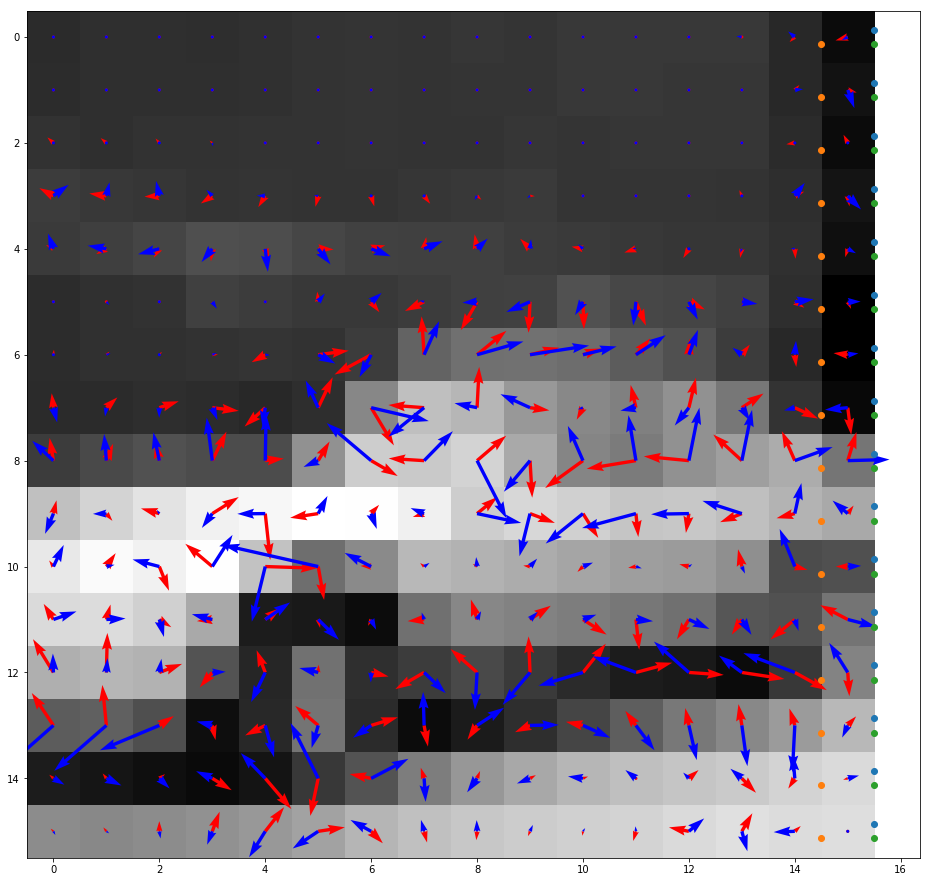

In [11]:
for level in range(0,max_level):
    U, V = np.meshgrid(range(0, imgslp2[level].shape[1]), range(0, imgslp2[level].shape[0]))
    l1 = (np.random.rand(imgslp2[level].shape[0],1)*(np.random.rand(imgslp2[level].shape[0],1)-0.5) + 1j*2*(np.random.rand(imgslp2[level].shape[0],1)-0.5))
    l1[:] = 0 + 1j

    for c in range(0, imgslp2[level].shape[1]):

        # Normalise the magnitude of the SLP2 value to stop it running away and becoming huge
        wdelta = (imgslp2[level][:,c,0]/np.abs(imgslp2[level][:,c,0])*np.exp(-1j*np.pi/12))**(slp2pyramid.rotratio[level,0]) # This should now contain the phase difference over one full pixel
        #print(np.angle(diffs[level][0,c,0]**0.5), np.angle(wdelta[0]**0.5)) # This shows it does
        #w.highpasses[level][:,c,0] = np.sqrt(np.abs(imgslp2[level][:,c,0]))*np.exp(1j*np.angle(np.multiply(l1.flatten(), wdelta**0.5)))
        spatialrec.highpasses[level][:,c,0] = np.sqrt(np.abs(imgslp2[level][:,c,0]))*np.multiply(l1.flatten(), wdelta**0.5)/np.abs(np.multiply(l1.flatten(), wdelta**0.5))
        u1 = np.multiply(l1.flatten(), wdelta).T
        if np.any(np.isnan(l1.flatten())):
            print(c)
            raise ValueError('Nans detected')
        
        # What should u1 actually be?
        #u1true = (dtcwt.sampling.sample_highpass(
        #        np.tile(dtcwtpyramid.highpasses[level][:,:,0].reshape(dtcwtpyramid.highpasses[level][:,:,0].shape[0], dtcwtpyramid.highpasses[level][:,:,0].shape[1], 1), [1,1,6]), 
        #        U[:,c]+0.5*1.035*np.cos(15*np.pi/180), V[:,c]-0.5*1.035*np.sin(15*np.pi/180), method='bilinear', sbs=[0])[0,:,:])
        omega_x = -1*np.pi/2.15 * (U[:,c]+0.5*d*np.cos(15*np.pi/180))
        omega_y = -3*np.pi/2.15 * (V[:,c]-0.5*d*np.sin(15*np.pi/180))
        u1lowpass = u1.flatten() * np.exp(-1j*(omega_x + omega_y))
        omega_x = -1*np.pi/2.15 * (U[:,c]+0.5*d*np.cos(15*np.pi/180))
        omega_y = -3*np.pi/2.15 * (V[:,c]+0.5*d*np.sin(15*np.pi/180))
        
        l1 = np.interp(V[:,c] + 0.5*d*np.sin(15*np.pi/180), \
                       V[:,c] - 0.5*d*np.sin(15*np.pi/180), \
                       u1lowpass) * np.exp(1j*(omega_x + omega_y))

#print((U[:,c]+1/1.035*np.cos(15*np.pi/180), (V[:,c]-0.5/1.035*np.sin(15*np.pi/180))))

imshow(misc.imresize(img, 2**-(level+1)), cmap='gray')
#xlim([-1,10])
#ylim([10,-1])
quiver(U, V, np.real(spatialrec.highpasses[level][:,:,0]), np.imag(spatialrec.highpasses[level][:,:,0]), color='r', scale=20)
quiver(U, V, np.real(dtcwtpyramid.highpasses[level][:,:,0]), np.imag(dtcwtpyramid.highpasses[level][:,:,0]), color='b', scale=20)
scatter(U[:,c]+0.5*d*np.cos(15*np.pi/180), V[:,c] - 0.5*d*np.sin(15*np.pi/180))
scatter(U[:,c]-0.5*d*np.cos(15*np.pi/180), V[:,c] + 0.5*d*np.sin(15*np.pi/180))
scatter(U[:,c]+0.5*d*np.cos(15*np.pi/180), V[:,c] + 0.5*d*np.sin(15*np.pi/180))

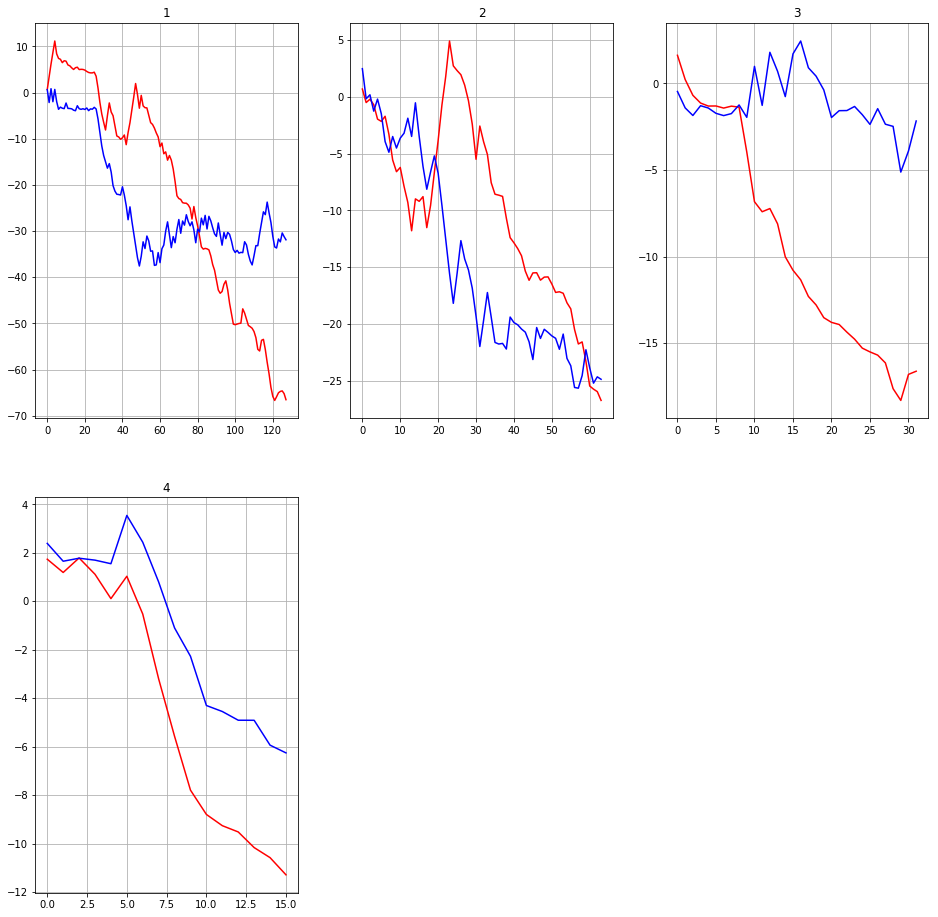

In [6]:
for l in range(0,max_level):
    plt.subplot(2, 3, l+1)
    plot(np.unwrap(np.angle(spatialrec.highpasses[l][int(imgslp2[l].shape[0]/2),:,0])), color='r')
    #plot(np.abs(w.highpasses[l][int(imgslp2[l].shape[0]/2),:,0]), color='g')
    plot(np.unwrap(np.angle(dtcwtpyramid.highpasses[l][int(imgslp2[l].shape[0]/2),:,0])), color='b')
    #print(np.gradient(np.angle(w.highpasses[l][int(imgslp2[l].shape[0]/2),:,0])))
    grid('on')
    title(l+1)

# Subband 6

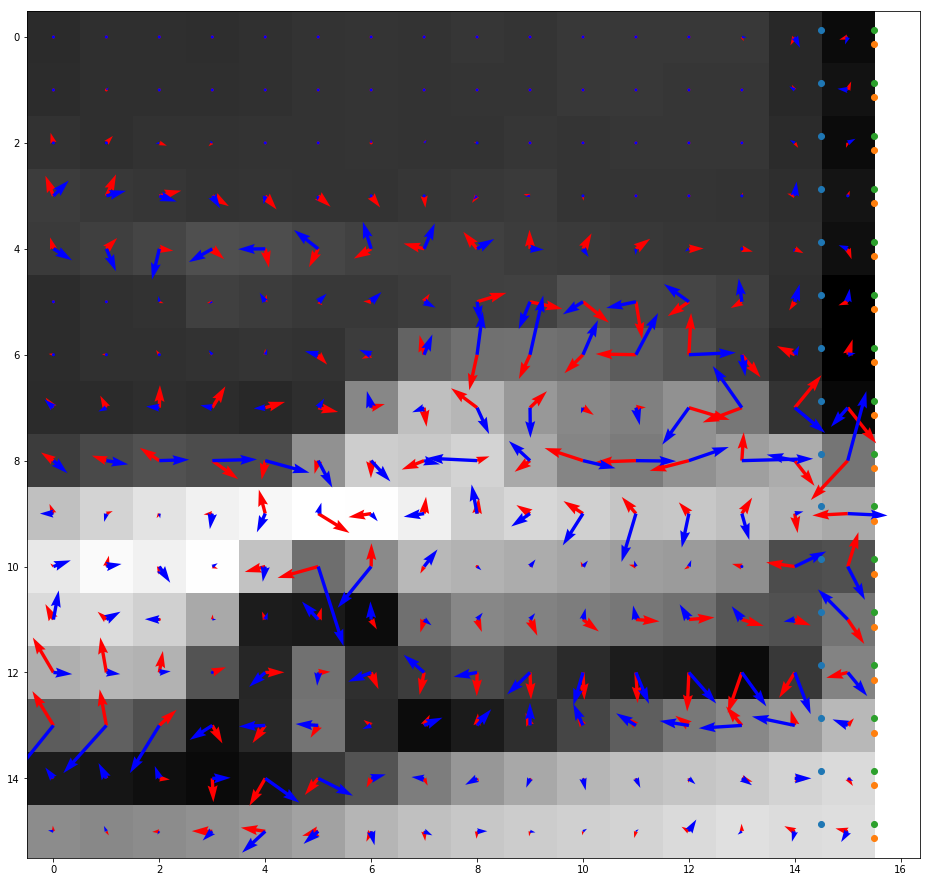

In [7]:
for level in range(0,max_level):
    U, V = np.meshgrid(range(0, imgslp2[level].shape[1]), range(0, imgslp2[level].shape[0]))
    u6 = (np.random.rand(imgslp2[level].shape[0],1)*(np.random.rand(imgslp2[level].shape[0],1)-0.5) + 1j*2*(np.random.rand(imgslp2[level].shape[0],1)-0.5))
    u6[:] = 0 + 1j
    #u6 = (dtcwt.sampling.sample_highpass(
    #            np.tile(dtcwtpyramid.highpasses[level][:,:,5].reshape(dtcwtpyramid.highpasses[level][:,:,5].shape[0], dtcwtpyramid.highpasses[level][:,:,5].shape[1], 1), [1,1,6]), 
    #            U[:,0]-0.5*1.035*np.cos(15*np.pi/180), V[:,0]-0.5*1.035*np.sin(15*np.pi/180), method='bilinear', sbs=[5]))[0,:,:].flatten()
    for c in range(0, imgslp2[level].shape[1]):

        # Normalise the magnitude of the SLP2 value to stop it running away and becoming huge
        wdelta = (imgslp2[level][:,c,5]/np.abs(imgslp2[level][:,c,5])*np.exp(-1j*11*np.pi/12))**(-slp2pyramid.rotratio[level,5]) # This should now contain the phase difference over one full pixel
        #print(np.angle(diffs[level][0,c,5]**0.5), np.angle(np.conj(wdelta[0])**0.5)) # This shows it does
        spatialrec.highpasses[level][:,c,5] = np.sqrt(np.abs(imgslp2[level][:,c,5]))*np.exp(1j*np.angle(np.multiply(u6.flatten(), wdelta**0.5)))
        l6 = np.multiply(u6.flatten(), wdelta).T
        if np.any(np.isnan(l6.flatten())):
            print(c)
            raise ValueError('Nans detected')
        omega_x = -1*np.pi/2.15 * (U[:,c]+0.5*d*np.cos(15*np.pi/180))
        omega_y =  3*np.pi/2.15 * (V[:,c]+0.5*d*np.sin(15*np.pi/180))
        l6lowpass = l6.flatten() * np.exp(-1j*(omega_x + omega_y))
        omega_x = -1*np.pi/2.15 * (U[:,c]+0.5*d*np.cos(15*np.pi/180))
        omega_y =  3*np.pi/2.15 * (V[:,c]-0.5*d*np.sin(15*np.pi/180))
        u6 = np.interp(V[:,c] - 0.5*d*np.sin(15*np.pi/180), \
                       V[:,c] + 0.5*d*np.sin(15*np.pi/180), \
                       l6lowpass) * np.exp(1j*(omega_x + omega_y))


imshow(misc.imresize(img, 2**-(level+1)), cmap='gray')
#xlim([-1,10])
#ylim([10,-1])
quiver(U, V, np.real(spatialrec.highpasses[level][:,:,5]), np.imag(spatialrec.highpasses[level][:,:,5]), color='r', scale=20)
quiver(U, V, np.real(dtcwtpyramid.highpasses[level][:,:,5]), np.imag(dtcwtpyramid.highpasses[level][:,:,5]), color='b', scale=20)
scatter(U[:,c]-0.5*d*np.cos(15*np.pi/180), V[:,c] - 0.5*d*np.sin(15*np.pi/180))
scatter(U[:,c]+0.5*d*np.cos(15*np.pi/180), V[:,c] + 0.5*d*np.sin(15*np.pi/180))
scatter(U[:,c]+0.5*d*np.cos(15*np.pi/180), V[:,c] - 0.5*d*np.sin(15*np.pi/180))

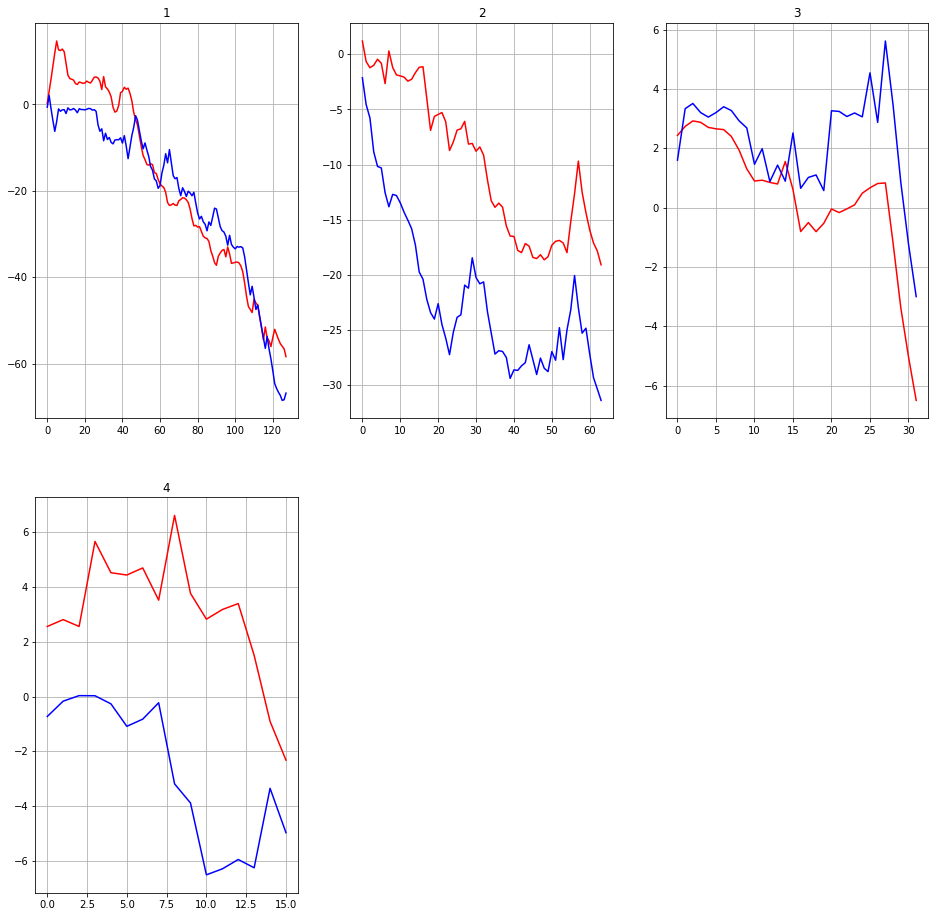

In [8]:
for l in range(0,max_level):
    plt.subplot(2, 3, l+1)
    plot(np.unwrap(np.angle(spatialrec.highpasses[l][int(imgslp2[l].shape[0]/2),:,5])), color='r')
    #plot(np.abs(w.highpasses[l][int(imgslp2[l].shape[0]/2),:,0]), color='g')
    plot(np.unwrap(np.angle(dtcwtpyramid.highpasses[l][int(imgslp2[l].shape[0]/2),:,5])), color='b')
    #print(np.gradient(np.unwrap(np.angle(w.highpasses[l][int(imgslp2[l].shape[0]/2),:,5]))))
    grid('on')
    title(l+1)

# Subband 3

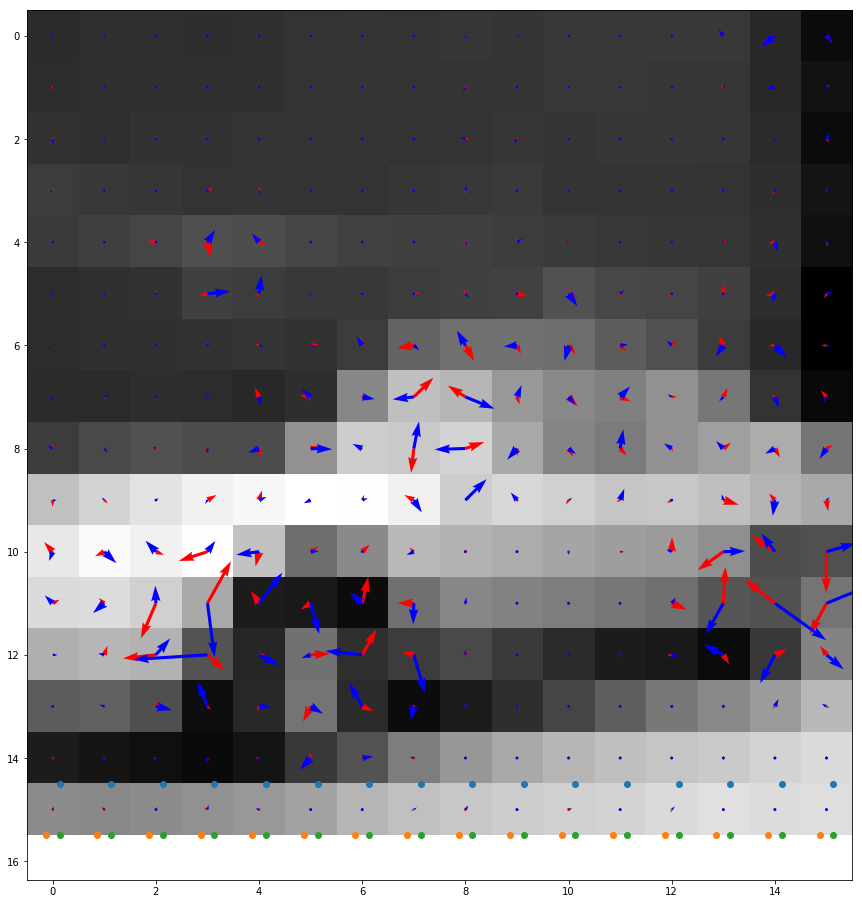

In [9]:
for level in range(0,max_level):
    U, V = np.meshgrid(range(0, imgslp2[level].shape[1]), range(0, imgslp2[level].shape[0]))
    u3 = (np.random.rand(imgslp2[level].shape[1],1)*(np.random.rand(imgslp2[level].shape[1],1)-0.5) + 1j*2*(np.random.rand(imgslp2[level].shape[1],1)-0.5))#
    u3[:] = 0 + 1j
    #l1 = (dtcwt.sampling.sample_highpass(
    #            np.tile(dtcwtpyramid.highpasses[level][:,0,0].reshape(dtcwtpyramid.highpasses[level][:,0,0].shape[0], 1, 1), [1,2,6]), 
    #            U[:,[0,0]]+0.5, V[:,[0,0]] + np.sin(15*np.pi/180), method='lanczos', sbs=[0])[:,0,:])

    for r in range(1, imgslp2[level].shape[0]):

        # Normalise the magnitude of the SLP2 value to stop it running away and becoming huge
        wdelta = (imgslp2[level][r,:,2]/np.abs(imgslp2[level][r,:,2])*np.exp(-1j*5*np.pi/12))**(-slp2pyramid.rotratio[level,2]) # This should now contain the phase difference over one full pixel
        #print(np.angle(diffs[level][r,0,2]**0.5), np.angle(wdelta[0]**0.5)) # This shows it does
        spatialrec.highpasses[level][r,:,2] = np.sqrt(np.abs(imgslp2[level][r,:,2]))*np.exp(1j*np.angle(np.multiply(u3.flatten(), wdelta**0.5)))
        l3 = np.multiply(u3.flatten(), wdelta).T
        if np.any(np.isnan(l3.flatten())):
            print(c)
            raise ValueError('Nans detected')

        # The values to be interpolated are shifted further from the axis by a constant amount
        #u3 = np.interp(np.arange(0,imgslp2[level].shape[1])-0.5 + 1/1.035*np.sin(15*np.pi/180), \
        #               np.arange(0,imgslp2[level].shape[1])-0.5, l3.flatten()*np.exp(1j*-3*np.pi/2.15*1/1.035*np.sin(15*np.pi/180)))

        omega_x = -3*np.pi/2.15 * (U[r,:]-0.5*d*np.cos(75*np.pi/180))
        omega_y = -1*np.pi/2.15 * (V[r,:]+0.5*d*np.sin(75*np.pi/180))       
        l3lowpass = l3.flatten() * np.exp(-1j*(omega_x + omega_y))
        omega_x = -3*np.pi/2.15 * (U[r,:]+0.5*d*np.cos(75*np.pi/180)) 
        omega_y = -1*np.pi/2.15 * (V[r,:]+0.5*d*np.sin(75*np.pi/180))
        u3 = np.interp(U[r,:] + 0.5*d*np.sin(15*np.pi/180), \
                       U[r,:] - 0.5*d*np.sin(15*np.pi/180), \
                       l3lowpass) * np.exp(1j*(omega_x + omega_y))
imshow(misc.imresize(img, 2**-(level+1)), cmap='gray')
#xlim([-1,10])
#ylim([10,-1])
quiver(U, V, np.real(spatialrec.highpasses[level][:,:,2]), np.imag(spatialrec.highpasses[level][:,:,2]), color='r', scale=20)
quiver(U, V, np.real(dtcwtpyramid.highpasses[level][:,:,2]), np.imag(dtcwtpyramid.highpasses[level][:,:,2]), color='b', scale=20)
scatter(U[r,:]+0.5*d*np.cos(75*np.pi/180), V[r,:] - 0.5*d*np.sin(75*np.pi/180))
scatter(U[r,:]-0.5*d*np.cos(75*np.pi/180), V[r,:] + 0.5*d*np.sin(75*np.pi/180))
scatter(U[r,:]+0.5*d*np.cos(75*np.pi/180), V[r,:] + 0.5*d*np.sin(75*np.pi/180))

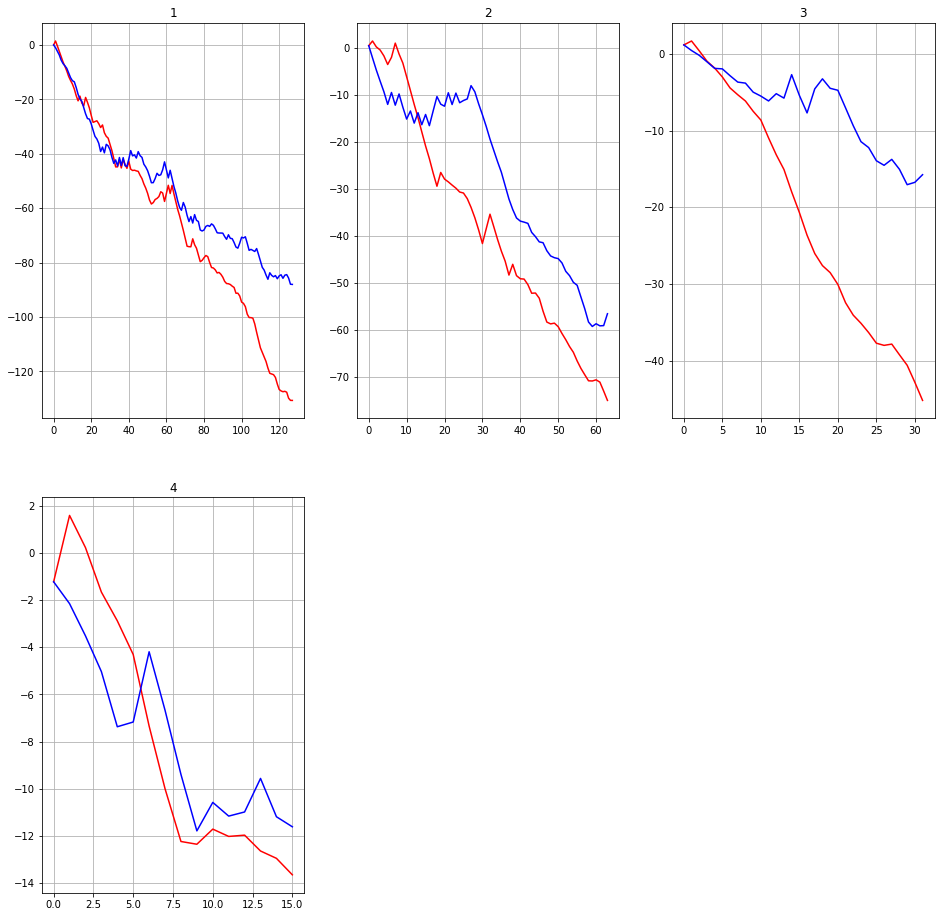

In [10]:
for l in range(0,max_level):
    plt.subplot(2, 3, l+1)
    plot(np.unwrap(np.angle(spatialrec.highpasses[l][:,int(imgslp2[l].shape[1]/2),2])), color='r')
    plot(np.unwrap(np.angle(dtcwtpyramid.highpasses[l][:,int(imgslp2[l].shape[1]/2),2])), color='b')
    grid('on')
    title(l+1)

# Subband 4

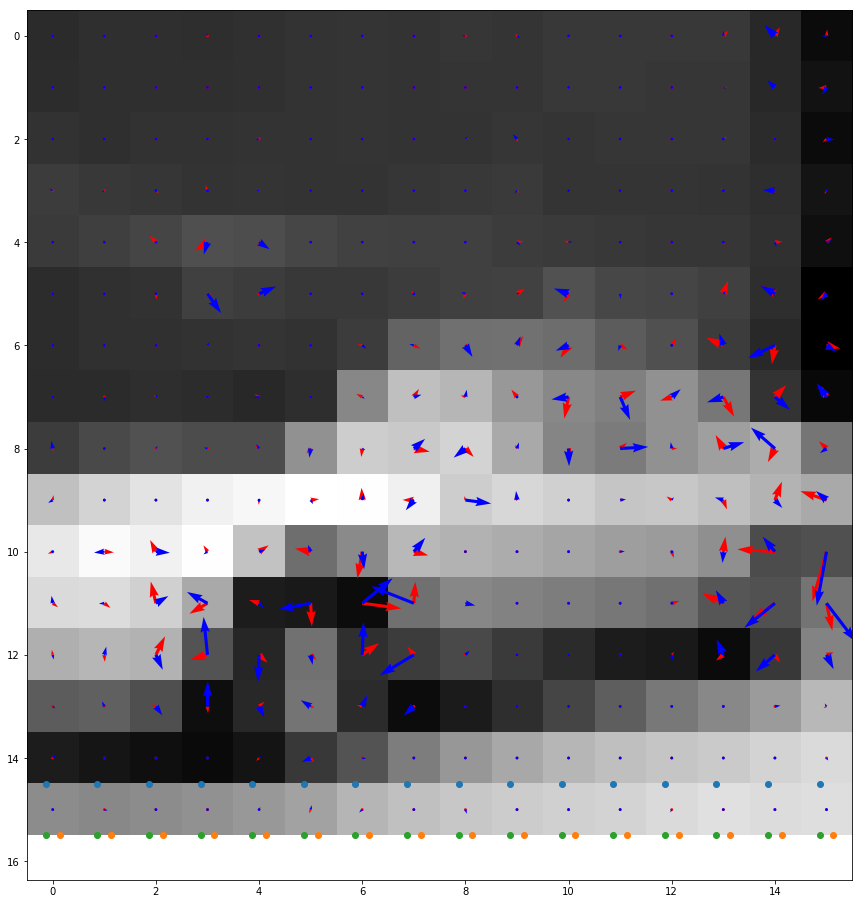

In [11]:
for level in range(0,max_level):
    U, V = np.meshgrid(range(0, imgslp2[level].shape[1]), range(0, imgslp2[level].shape[0]))
    # Initialise the first coefficient phases and magnitudes randomly
    u4 = (np.random.rand(imgslp2[level].shape[1],1)*(np.random.rand(imgslp2[level].shape[1],1)-0.5) + 1j*2*(np.random.rand(imgslp2[level].shape[1],1)-0.5))
    u4[:] = 0 + 1j
    # Initialise by interpolating the true values
    #u4 = (dtcwt.sampling.sample_highpass(
    #            np.tile(dtcwtpyramid.highpasses[level][0,:,3].reshape(1, dtcwtpyramid.highpasses[level].shape[1], 1), [2,1,6]), 
    #            U[0,:] - np.sin(15*np.pi/180), V[0,:]-0.5, method='bilinear', sbs=[3])[0,:,0])

    for r in range(0, imgslp2[level].shape[0]):

        # Normalise the magnitude of the SLP2 value to stop it running away and becoming huge
        wdelta = (imgslp2[level][r,:,3]/np.abs(imgslp2[level][r,:,3])*np.exp(-1j*7*np.pi/12))**(-slp2pyramid.rotratio[level,3]) # This should now contain the phase difference over one full pixel
        #print(np.angle(diffs[level][r,0,3]**0.5), np.angle(wdelta[0]**0.5)) # This shows it does
        spatialrec.highpasses[level][r,:,3] = np.sqrt(np.abs(imgslp2[level][r,:,3]))*np.exp(1j*(np.angle(np.multiply(u4.flatten(), wdelta**0.5))))
        l4 = np.multiply(u4.flatten(), wdelta).T
        if np.any(np.isnan(l4.flatten())):
            print(c)
            raise ValueError('Nans detected')

        omega_x = -3*np.pi/2.15 * (U[r,:]+0.5*d*np.sin(15*np.pi/180))
        omega_y = 1*np.pi/2.15 * (V[r,:]+0.5*d*np.cos(15*np.pi/180))       
        l4lowpass = l4.flatten() * np.exp(-1j*(omega_x + omega_y))
        omega_x = -3*np.pi/2.15 * (U[r,:]-0.5*d*np.sin(15*np.pi/180))
        omega_y = 1*np.pi/2.15 * (V[r,:]+0.5*d*np.cos(15*np.pi/180))
        u4 = np.interp(U[r,:] - 0.5*d*np.sin(15*np.pi/180), \
                       U[r,:] + 0.5*d*np.sin(15*np.pi/180), \
                       l4lowpass) * np.exp(1j*(omega_x + omega_y))

imshow(misc.imresize(img, 2**-(level+1)), cmap='gray')
#xlim([-1,10])
#ylim([10,-1])
quiver(U, V, np.real(spatialrec.highpasses[level][:,:,3]), np.imag(spatialrec.highpasses[level][:,:,3]), color='r', scale=20)
quiver(U, V, np.real(dtcwtpyramid.highpasses[level][:,:,3]), np.imag(dtcwtpyramid.highpasses[level][:,:,3]), color='b', scale=20)
scatter(U[r,:]-0.5*d*np.sin(15*np.pi/180), V[r,:] - 0.5*d*np.cos(15*np.pi/180))
scatter(U[r,:]+0.5*d*np.sin(15*np.pi/180), V[r,:] + 0.5*d*np.cos(15*np.pi/180))
scatter(U[r,:]-0.5*d*np.sin(15*np.pi/180), V[r,:] + 0.5*d*np.cos(15*np.pi/180))

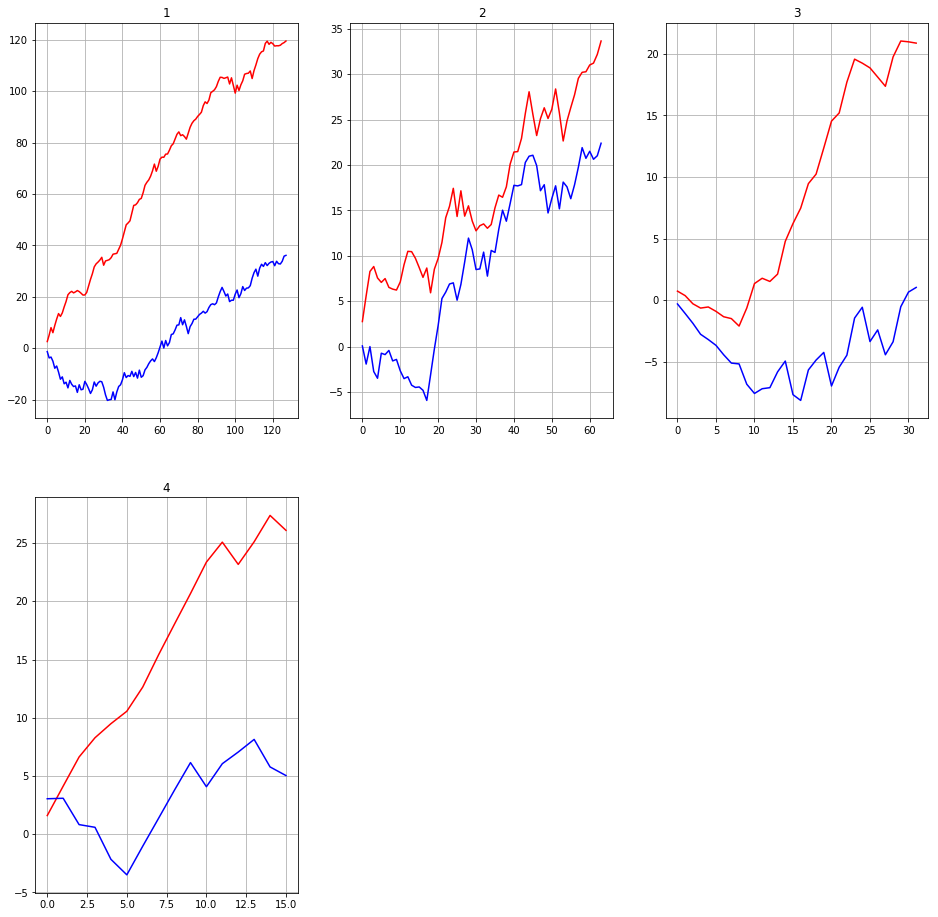

In [12]:
for l in range(0,max_level):
    plt.subplot(2, 3, l+1)
    plot(np.unwrap(np.angle(spatialrec.highpasses[l][:,int(imgslp2[l].shape[1]/2),3])), color='r')
    plot(np.unwrap(np.angle(dtcwtpyramid.highpasses[l][:,int(imgslp2[l].shape[1]/2),3])), color='b')
    grid('on')
    title(l+1)

# Subband 2

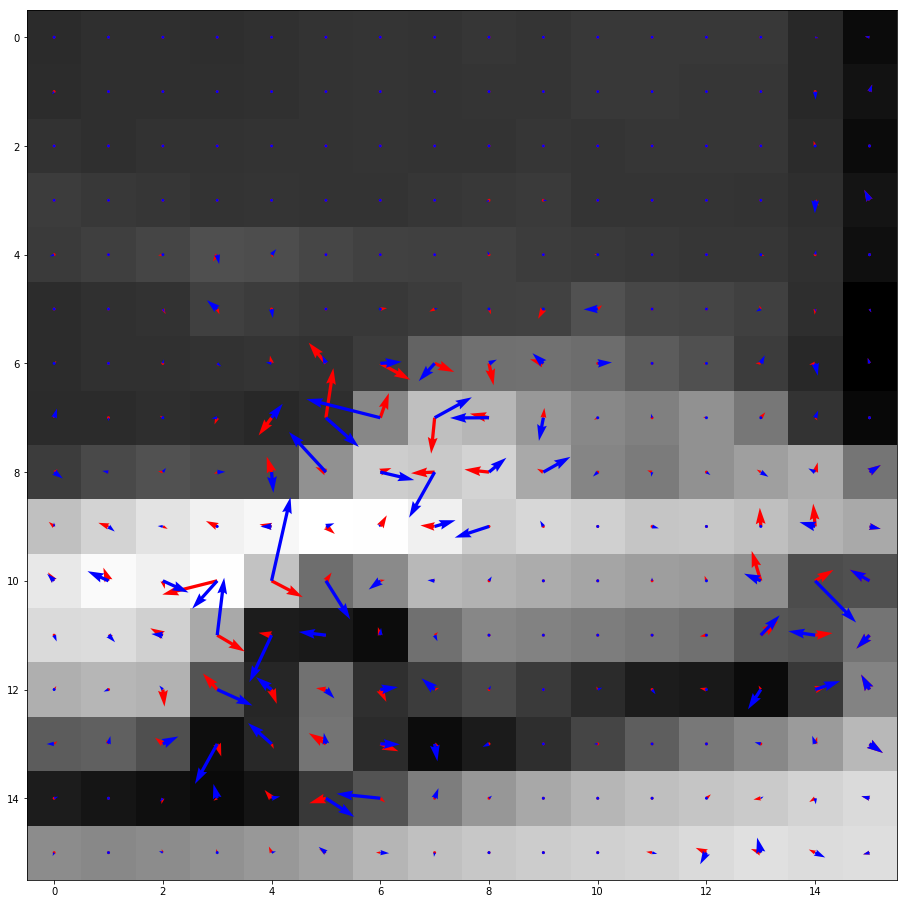

In [13]:
#spatialrec.highpasses[level][:,:,1] = 0
for level in range(0, max_level):
    U, V = np.meshgrid(range(0, imgslp2[level].shape[1]), range(0, imgslp2[level].shape[0]))
    for c in range(0,imgslp2[level].shape[1]):
        l2 = 0 + 1j
        for r in range(1, imgslp2[level].shape[0]+1):
            if r+c > imgslp2[level].shape[1]-1:
                break
            wdelta = (imgslp2[level][-r,r-1+c,1]/np.abs(imgslp2[level][-r,r-1+c,1])*np.exp(-1j**np.pi/4))**(slp2pyramid.rotratio[level,1]) # This should now contain the phase difference over one full pixel
            #print(np.angle(diffs[level][r,0,3]**0.5), np.angle(wdelta[0]**0.5)) # This shows it does
            spatialrec.highpasses[level][-r,r-1+c,1] = np.sqrt(np.abs(imgslp2[level][-r,r-1+c,1]))*np.exp(1j*(np.angle(np.multiply(l2, wdelta**0.5))))
            u2 = np.multiply(l2, wdelta).T
            l2 = np.multiply(l2, wdelta**(np.sqrt(2))).T

    for r in range(1, imgslp2[level].shape[0]+1):

        l2 = 0 + 1j
        for c in np.arange(0, imgslp2[level].shape[0]):
            if r+c >imgslp2[level].shape[0]-1:
                break
            wdelta = (imgslp2[level][-r-c,c,1]/np.abs(imgslp2[level][-r-c,c,1])*np.exp(-1j**np.pi/4))**(-slp2pyramid.rotratio[level,1]) # This should now contain the phase difference over one full pixel
            #print(np.angle(diffs[level][r,0,3]**0.5), np.angle(wdelta[0]**0.5)) # This shows it does
            spatialrec.highpasses[level][-r-c,c,1] = np.sqrt(np.abs(imgslp2[level][-r-c,c,1]))*np.exp(1j*(np.angle(np.multiply(l2, wdelta**0.5))))
            u2 = np.multiply(l2, wdelta).T
            l2 = np.multiply(l2, wdelta**(np.sqrt(2))).T

imshow(misc.imresize(img, 2**-(level+1)), cmap='gray')
#xlim([-1,10])
#ylim([10,-1])
quiver(U, V, np.real(spatialrec.highpasses[level][:,:,1]), np.imag(spatialrec.highpasses[level][:,:,1]), color='r', scale=20)
quiver(U, V, np.real(dtcwtpyramid.highpasses[level][:,:,1]), np.imag(dtcwtpyramid.highpasses[level][:,:,1]), color='b', scale=20)

# Subband 5

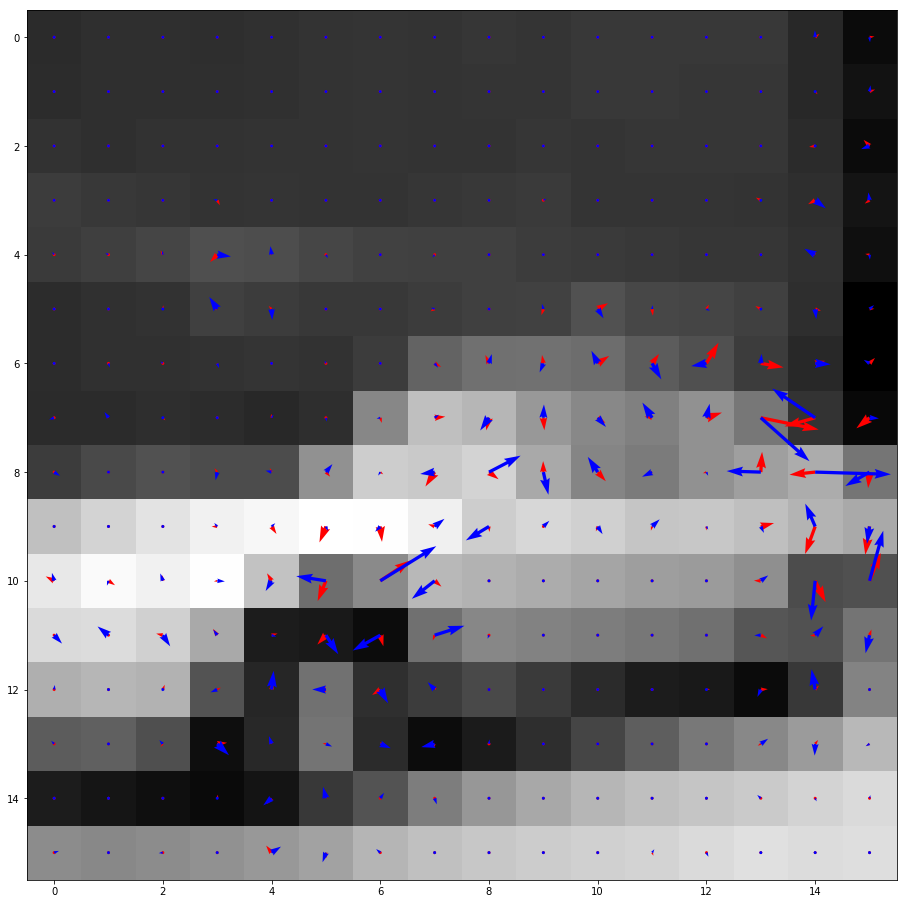

In [14]:
#spatialrec.highpasses[level][:,:,4] = 0
for level in range(0, max_level):
    U, V = np.meshgrid(range(0, imgslp2[level].shape[1]), range(0, imgslp2[level].shape[0]))
    for c in range(0,imgslp2[level].shape[1]):
        u5 = 0 + 1j
        for r in range(0, imgslp2[level].shape[0]):
            if r+c > imgslp2[level].shape[1]-1:
                break
            wdelta = (imgslp2[level][r,r+c,4]/np.abs(imgslp2[level][r,r+c,4])*np.exp(-1j**3*np.pi/4))**(-slp2pyramid.rotratio[level,4]) # This should now contain the phase difference over one full pixel
            #print(np.angle(diffs[level][r,0,3]**0.5), np.angle(wdelta[0]**0.5)) # This shows it does
            spatialrec.highpasses[level][r,r+c,4] = np.sqrt(np.abs(imgslp2[level][r,r+c,4]))*np.exp(1j*(np.angle(np.multiply(u5, wdelta**0.5))))
            l5 = np.multiply(u5, wdelta).T
            u5 = np.multiply(u5, wdelta**(np.sqrt(2))).T

    for r in range(0,imgslp2[level].shape[0]):
        u5 = 0 + 1j
        for c in range(0, imgslp2[level].shape[1]):
            if r+c > imgslp2[level].shape[1]-1:
                break
            wdelta = (imgslp2[level][r+c,c,4]/np.abs(imgslp2[level][r+c,c,4])*np.exp(-1j**3*np.pi/4))**(-slp2pyramid.rotratio[level,4]) # This should now contain the phase difference over one full pixel
            #print(np.angle(diffs[level][r,0,3]**0.5), np.angle(wdelta[0]**0.5)) # This shows it does
            spatialrec.highpasses[level][r+c,c,4] = np.sqrt(np.abs(imgslp2[level][r+c,c,4]))*np.exp(1j*(np.angle(np.multiply(u5, wdelta**0.5))))
            l5 = np.multiply(u5, wdelta).T
            u5 = np.multiply(u5, wdelta**(np.sqrt(2))).T

imshow(misc.imresize(img, 2**-(level+1)), cmap='gray')
#xlim([-1,10])
#ylim([10,-1])
quiver(U, V, np.real(spatialrec.highpasses[level][:,:,4]), np.imag(spatialrec.highpasses[level][:,:,4]), color='r', scale=20)
quiver(U, V, np.real(dtcwtpyramid.highpasses[level][:,:,4]), np.imag(dtcwtpyramid.highpasses[level][:,:,4]), color='b', scale=20)

[ 0.41345791]
1.0


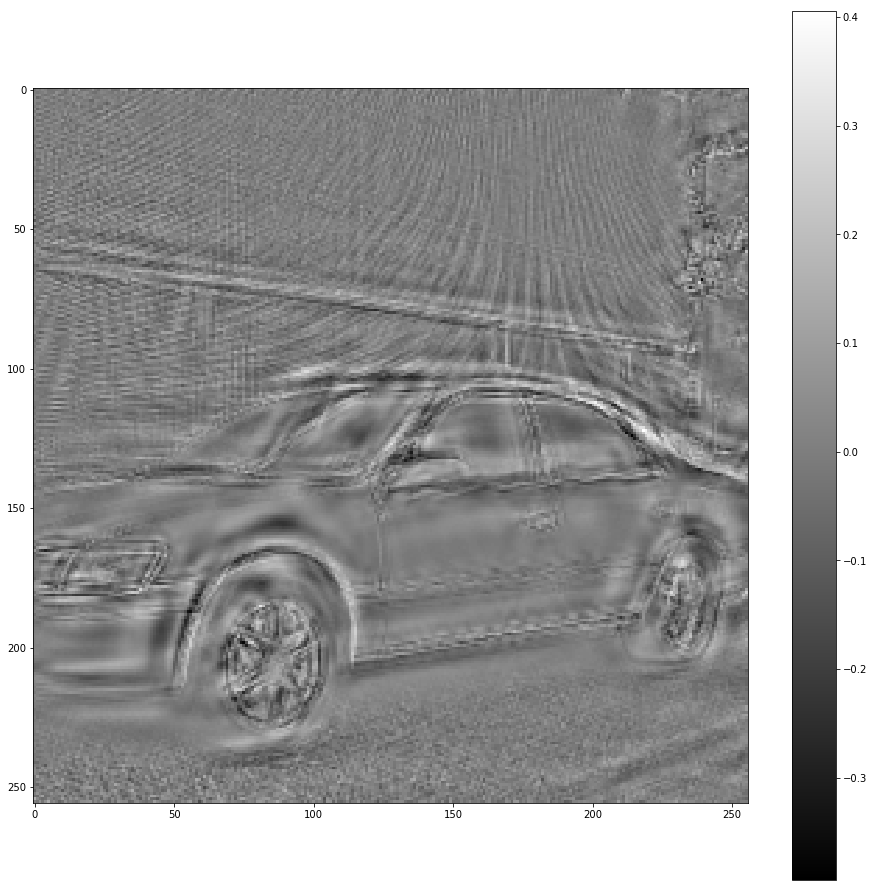

In [15]:
gm = np.ones([6,5])
#gm[:,[2,4]] = 0
#gm = np.ones([6, 6])
imshow(transform.inverse(dtcwtpyramid, gain_mask=gm)-transform.inverse(spatialrec, gain_mask=gm), cmap='gray')
spatialrec.lowpass[:,:] = 0
imshow(transform.inverse(spatialrec, gain_mask=gm), cmap='gray')
colorbar()
print(np.mean(np.abs(transform.inverse(dtcwtpyramid)-transform.inverse(spatialrec))).flatten())
print(img.max() - img.min())

In [16]:
1/np.cos(15*np.pi/180)

1.035276180410083

In [17]:
np.sqrt(3**2 + 1)/2

1.5811388300841898

# Scale-based reconstruction

In [27]:
scalerec.highpasses[max_level-1][:,:,:] = spatialrec.highpasses[max_level-1][:,:,:]
#scalerec.highpasses[max_level-1][:,:,:] = dtcwtpyramid.highpasses[max_level-1][:,:,:]

for level in range(0, max_level-1):
    U, V = np.meshgrid(range(0, imgslp2[level].shape[1]), range(0, imgslp2[level].shape[0]))
    Uc, Vc = np.meshgrid(range(0, imgslp2[max_level-1].shape[1]), range(0, imgslp2[max_level-1].shape[0]))
    #scatter((U-0.5)/2**(max_level-(level+1)), (V-0.5)/2**(max_level-(level+1)))
    #scatter(Uc,Vc)
    #scalerec.highpasses[level][:,:,:] = dtcwt.sampling.sample_highpass(scalerec.highpasses[max_level-1], \
    #                                                            (U-0.5)/2**(max_level-(level+1)), \
    #                                                            (V-0.5)/2**(max_level-(level+1)), \
    #                                                            method='lanczos', sbs=[0,1,2,3,4,5])
    
    scalerec.highpasses[level][:,:,:] = dtcwt.sampling.rescale_highpass(scalerec.highpasses[max_level-1][:,:,:], scalerec.highpasses[level].shape, method='lanczos', sbs=[0,1,2,3,4,5])
    #scalerec.highpasses[level][:,:,:] = np.sqrt(np.abs(dtcwt.sampling.rescale(imgslp2[max_level-1], imgslp2[level].shape)))*np.exp(1j*np.angle(scalerec.highpasses[level][:,:,:]))
    scalerec.highpasses[level][:,:,:] = np.sqrt(np.abs(imgslp2[level]))*np.exp(1j*stats.circmean(np.angle(scalerec.highpasses[level]), np.angle(spatialrec.highpasses[level])))

[ 0.09627349]
1.0


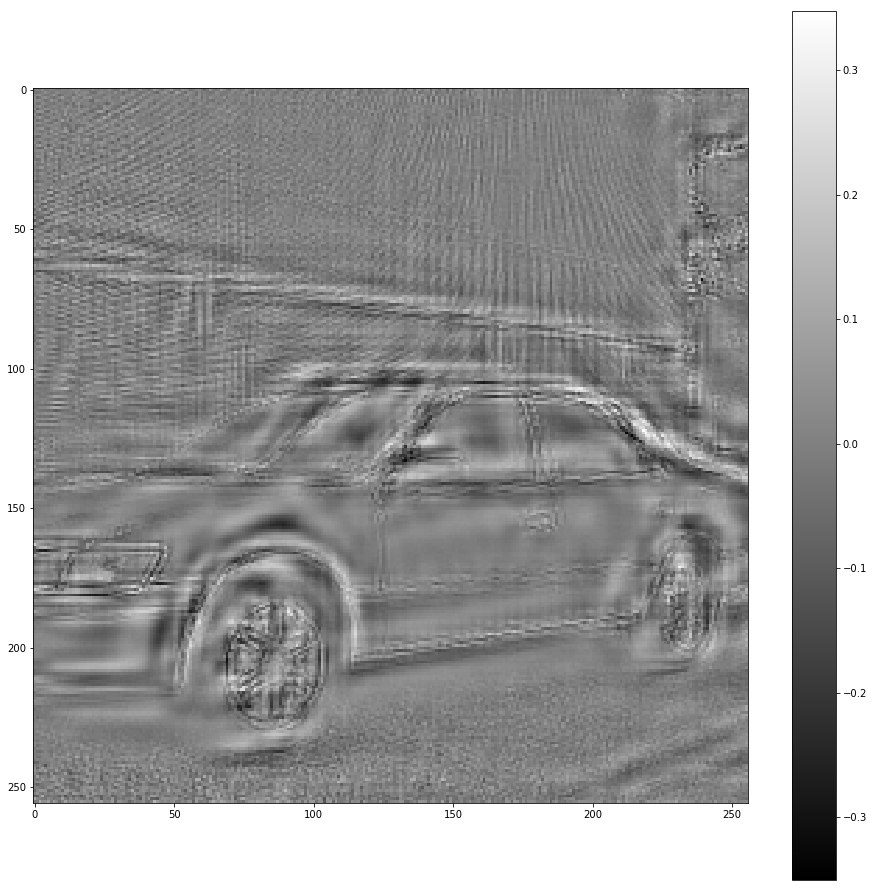

In [28]:
gm = np.ones([6,5])
#gm[:,[2,4]] = 0
#gm = np.ones([6, 6])
dtcwtpyramid.lowpass[:,:] = 0
imshow(transform.inverse(dtcwtpyramid, gain_mask=gm), cmap='gray')
scalerec.lowpass[:,:] = 0
imshow(transform.inverse(scalerec, gain_mask=gm), cmap='gray')
colorbar()
print(np.mean(np.abs(transform.inverse(dtcwtpyramid)-transform.inverse(scalerec))).flatten())
print(img.max() - img.min())

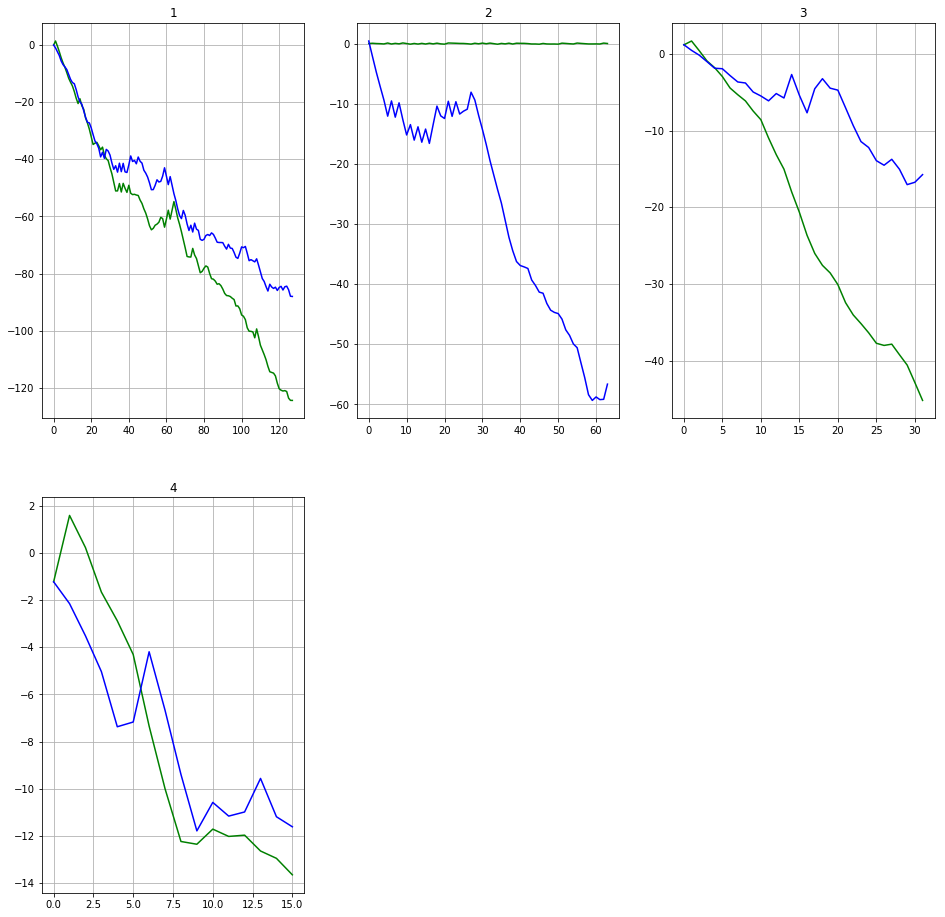

In [26]:
for l in range(0,max_level):
    plt.subplot(2, 3, l+1)
    plot(np.unwrap(np.angle(scalerec.highpasses[l][:,int(imgslp2[l].shape[1]/2),2])), color='g')
    plot(np.unwrap(np.angle(dtcwtpyramid.highpasses[l][:,int(imgslp2[l].shape[1]/2),2])), color='b')
    #plot(np.unwrap(stats.circmean(np.angle([dtcwtpyramid.highpasses[l][:,int(imgslp2[l].shape[1]/2),3], spatialrec.highpasses[l][:,int(imgslp2[l].shape[1]/2),3]]), axis=0)), color='k')
    grid('on')
    title(l+1)

(0, 30)

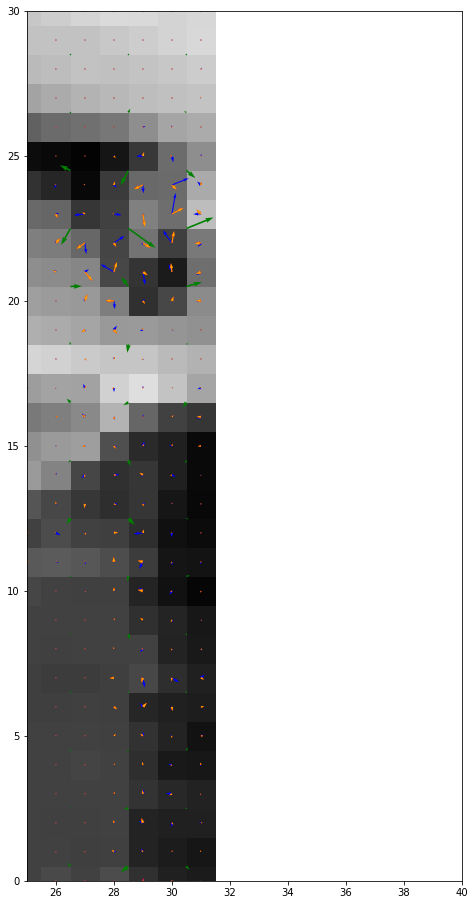

In [21]:
imshow(misc.imresize(img, 2**-(len(scalerec.highpasses)-1)), cmap='gray')
#xlim([-1,10])
#ylim([10,-1])
sb = 2 # Subbands 1 and 4 will be the true vlues because they are already set to the ground truth
U, V = np.meshgrid(range(0, dtcwtpyramid.highpasses[-1].shape[1]), range(0, dtcwtpyramid.highpasses[-1].shape[0]))
quiver(U*2+0.5, V*2+0.5, np.real(dtcwtpyramid.highpasses[-1][:,:,sb]), np.imag(dtcwtpyramid.highpasses[-1][:,:,sb]), color='g', scale=20)
U, V = np.meshgrid(range(0, scalerec.highpasses[-2].shape[1]), range(0, scalerec.highpasses[-2].shape[0]))
quiver(U, V, np.real(dtcwtpyramid.highpasses[-2][:,:,sb]), np.imag(dtcwtpyramid.highpasses[-2][:,:,sb]), color='b', scale=20)
quiver(U, V, np.real(spatialrec.highpasses[-2][:,:,sb]), np.imag(spatialrec.highpasses[-2][:,:,sb]), color='r', scale=20)
quiver(U, V, np.real(scalerec.highpasses[-2][:,:,sb]), np.imag(scalerec.highpasses[-2][:,:,sb]), color='orange', scale=20)
xlim([25,40])
ylim([0,30])